<a href="https://colab.research.google.com/github/ar851060/TabularWithBert/blob/main/CompressClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import gzip
import numpy as np
import pandas as pd
np.random.seed(42)

#  compression

In [ ]:
df = pd.read_csv("/content/v2_Latest_Data_Science_Salaries.csv").drop(["Salary","Salary Currency"], axis = 1)
df.head()

,Job Title,Employment Type,Experience Level,Expertise Level,Company Location,Salary in USD,Employee Residence,Company Size,Year
0,Machine Learning Manager,Full-Time,Senior,Expert,United States,129562,Germany,Large,2023
1,BI Data Analyst,Full-Time,Entry,Junior,Kenya,50000,Kenya,Small,2023
2,AI Engineer,Full-Time,Senior,Expert,United States,227850,United States,Medium,2023
3,AI Engineer,Full-Time,Senior,Expert,United States,180500,United States,Medium,2023
4,Data Analyst,Full-Time,Mid,Intermediate,United States,90000,United States,Medium,2023


In [ ]:
cols = df.columns.values.tolist()
cols.remove("Salary in USD")
df["text"] = ["[CLS]" + str(i).replace("'","").replace("{","").replace("}","") + "[SEP]" for i in df.to_dict("records")]
df = df.drop(cols, axis = 1)
train_text, temp_df, train_labels, temp_labels = train_test_split(df.drop("Salary in USD", axis = 1), df['Salary in USD'])
# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_df, temp_labels)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_labels = scaler.fit_transform(np.array(train_labels).reshape(-1, 1))
val_labels = scaler.transform(np.array(val_labels).reshape(-1, 1))
test_labels = scaler.transform(np.array(test_labels).reshape(-1, 1))
temp_labels = scaler.transform(np.array(temp_labels).reshape(-1, 1))

In [ ]:
train_text = train_text["text"].tolist()
test_text = test_text["text"].tolist()
temp_df = temp_df["text"].tolist()
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()
temp_labels = temp_labels.flatten
c2_list = [len(gzip.compress(x.encode('utf-8'))) for x in train_text]
c1_list = [len(gzip.compress(x.encode('utf-8'))) for x in test_text]
ct_list = [len(gzip.compress(x.encode('utf-8'))) for x in temp_df]

In [ ]:
k = 2
preds = []
for i,x1 in enumerate(test_text):
    if (i+1)%10 == 1:
        print(f"{i+1} // 217")
    c1 = c1_list[i]
    distance_from_x1 = []
    for j,x2 in enumerate(train_text):
        c2 = c2_list[j]
        x1x2 = " ".join([x1,x2])
        c12 = len(gzip.compress(x1x2.encode('utf-8')))
        ncd = (c12-min(c1,c2))/max(c1,c2)
        distance_from_x1.append(ncd)
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = train_labels[sorted_idx[:k]]
    predict_class = np.mean(top_k_class)
    preds.append(predict_class)

1 // 217
11 // 217
21 // 217
31 // 217
41 // 217
51 // 217
61 // 217
71 // 217
81 // 217
91 // 217
101 // 217
111 // 217
121 // 217
131 // 217
141 // 217
151 // 217
161 // 217
171 // 217
181 // 217
191 // 217
201 // 217
211 // 217


In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_labels, preds))

0.013970962698753833


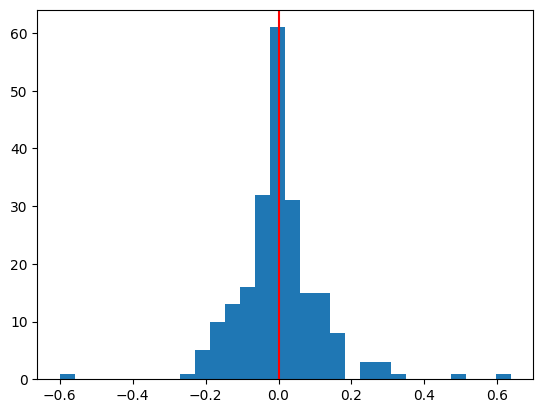

In [ ]:
import matplotlib.pyplot as plt
plt.hist((test_labels-preds), bins = 30)
plt.axvline(x = 0, color = "red")

# LGBM

In [ ]:
df = pd.read_csv("/content/v2_Latest_Data_Science_Salaries.csv").drop(["Salary","Salary Currency"], axis = 1)
df.head()

,Job Title,Employment Type,Experience Level,Expertise Level,Company Location,Salary in USD,Employee Residence,Company Size,Year
0,Machine Learning Manager,Full-Time,Senior,Expert,United States,129562,Germany,Large,2023
1,BI Data Analyst,Full-Time,Entry,Junior,Kenya,50000,Kenya,Small,2023
2,AI Engineer,Full-Time,Senior,Expert,United States,227850,United States,Medium,2023
3,AI Engineer,Full-Time,Senior,Expert,United States,180500,United States,Medium,2023
4,Data Analyst,Full-Time,Mid,Intermediate,United States,90000,United States,Medium,2023


In [ ]:
df["Experience Level"] = df["Experience Level"].replace(dict(zip(['Senior', 'Entry', 'Mid', 'Executive'], [3,1,2,4])))
df["Expertise Level"] = df["Expertise Level"].replace(dict(zip(['Expert', 'Junior', 'Intermediate', 'Director'], [3,1,2,4])))
df["Company Size"] = df["Company Size"].replace(dict(zip(['Large', 'Small', 'Medium'], [3,1,2])))

In [ ]:
train_text, temp_df, train_labels, temp_labels = train_test_split(df.drop("Salary in USD", axis = 1), df['Salary in USD'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_df, temp_labels)
cat_cols = train_text.columns.values.tolist().remove("Year")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
train_text[["Job Title","Employment Type","Company Location","Employee Residence"]] = encoder.fit_transform(train_text[["Job Title","Employment Type","Company Location","Employee Residence"]])
test_text[["Job Title","Employment Type","Company Location","Employee Residence"]] = encoder.transform(test_text[["Job Title","Employment Type","Company Location","Employee Residence"]])
temp_df[["Job Title","Employment Type","Company Location","Employee Residence"]] = encoder.transform(temp_df[["Job Title","Employment Type","Company Location","Employee Residence"]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_labels = scaler.fit_transform(np.array(train_labels).reshape(-1, 1))
val_labels = scaler.transform(np.array(val_labels).reshape(-1, 1))
test_labels = scaler.transform(np.array(test_labels).reshape(-1, 1))
temp_labels = scaler.transform(np.array(temp_labels).reshape(-1, 1))

In [ ]:
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()
temp_labels = temp_labels.flatten()

In [ ]:
lgbm = LGBMRegressor()
lgbm.fit(train_text, train_labels, categorical_feature = cat_cols)
y_pred = lgbm.predict(test_text)

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_labels, y_pred))

0.015214935626166885


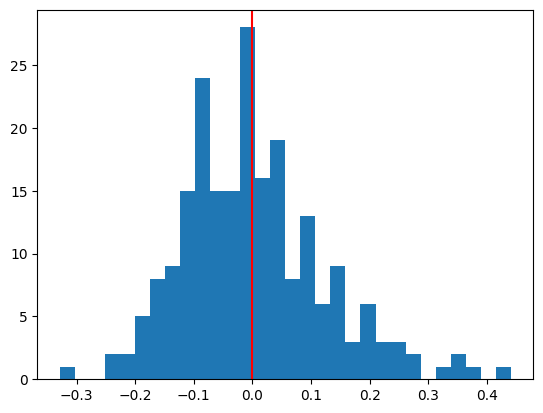

In [ ]:
import matplotlib.pyplot as plt
plt.hist((test_labels-y_pred), bins = 30)
plt.axvline(x = 0, color = "red")

In [ ]:
pd.DataFrame({"features":lgbm.feature_name_, "importance":lgbm.feature_importances_}).sort_values("importance",ascending = False)

,features,importance
0,Job_Title,1344
5,Employee_Residence,415
4,Company_Location,395
2,Experience_Level,341
7,Year,301
6,Company_Size,204
1,Employment_Type,0
3,Expertise_Level,0


In [ ]:
df = pd.read_csv("/content/v2_Latest_Data_Science_Salaries.csv").drop(["Salary","Salary Currency"], axis = 1)

<BarContainer object of 3470 artists>

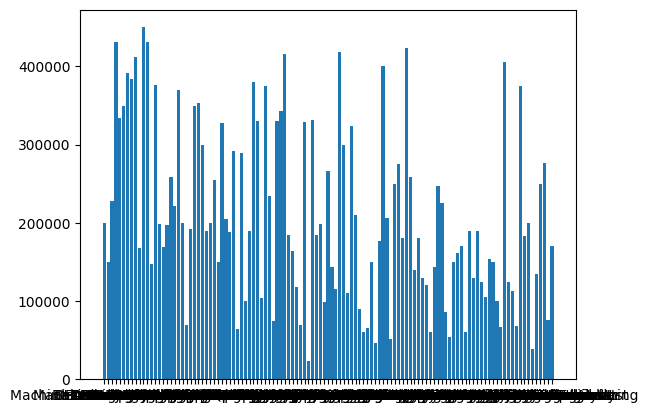

In [ ]:
plt.bar(df["Job Title"], df["Salary in USD"])

In [ ]:
df.describe(include = 'O')

,Job Title,Employment Type,Experience Level,Expertise Level,Company Location,Employee Residence,Company Size
count,3470,3470,3470,3470,3470,3470,3470
unique,115,4,4,4,71,83,3
top,Data Engineer,Full-Time,Senior,Expert,United States,United States,Medium
freq,732,3431,2187,2187,2616,2571,2859
